In [34]:
import numpy as np
import CLAMS as clams
from tqdm import tqdm
from competitors import *
import json
import warnings
warnings.filterwarnings("ignore")
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

with open("../scatterplots/sampling/sampled_datasets_manual_sample.json", "r") as f:
	datasets = json.load(f)
	
with open("../scatterplots/sampling/sampled_datasets_training.json", "r") as f:
	datasets_training = json.load(f)


## remove datasets in datasets_Training
for dataset in datasets_training:
	if f"{dataset}.npy" in datasets:
		datasets.remove(f"{dataset}.npy")


In [17]:
size_list = []
cluster_num_list = []
clams_list = []

cs = clams.ClusterAmbiguity(mode="entropy")

for _ in range(20):
	for dataset in tqdm(datasets):
		splot = np.load(f"../scatterplots/scatterplots/{dataset}")
		
		## minmax normalize
		splot = (splot - splot.min(axis=0)) / (splot.max(axis=0) - splot.min(axis=0))
		
		splot_point_num = np.random.randint(100, 20000)
		if splot.shape[0] > splot_point_num:
			splot = splot[np.random.choice(splot.shape[0], splot_point_num, replace=False)]
		if splot.shape[0] < splot_point_num:
			splot = np.concatenate(
				[splot, 
					splot[np.random.choice(splot.shape[0], splot_point_num-splot.shape[0], replace=True)] + np.random.uniform(-0.1, 0.1, size=(splot_point_num-splot.shape[0], 2))])
		

		
		try:
			start = time.time()
			ambiguity = cs.fit(splot)
			cluster_num = cs.optimal_n_comp
			end = time.time()
		except:
			continue
		clams_list.append(end-start)
		cluster_num_list.append(cluster_num)
		size_list.append(splot.shape[0])
  

100%|██████████| 60/60 [04:57<00:00,  4.95s/it]


In [18]:
np.save("./scalability/sizes.npy", np.array(size_list))
np.save("./scalability/cluster_num.npy", np.array(cluster_num_list))
np.save("./scalability/clams.npy", np.array(clams_list))


Correlation between size and time: (0.8233278463898384, 1.7819425708013475e-296)
Correlation between cluster num and time: (-0.08473181834801563, 0.0033358307628270087)


<AxesSubplot:xlabel='cluster_nums', ylabel='clams_time'>

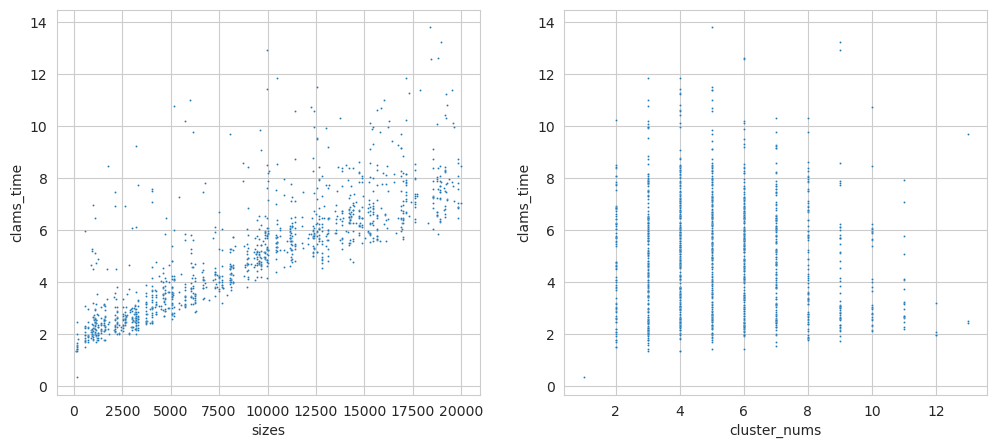

In [35]:
sizes = np.load("./scalability/sizes.npy")
cluster_nums = np.load("./scalability/cluster_num.npy")
clams_time = np.load("./scalability/clams.npy")

clams_time


print(f"Correlation between size and time: {pearsonr(sizes, clams_time)}")
print(f"Correlation between cluster num and time: {pearsonr(cluster_nums, clams_time)}")

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x="sizes", y="clams_time", data=pd.DataFrame({"sizes": sizes, "clams_time": clams_time}),ax=ax[0], s=2)
sns.scatterplot(x="cluster_nums", y="clams_time", data=pd.DataFrame({"cluster_nums": cluster_nums, "clams_time": clams_time}),  ax=ax[1], s=2)